In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import random
import IPython.display as display
from tqdm import tqdm
from collections import Counter

Image Dimensions: 

Counter({((1400, 1050), 'drone'): 835,
         ((1400, 1050), 'Bird+2_Blade_rotor'): 815,
         ((1400, 1050), '2_blade_rotor'): 800,
         ((1400, 1050), '3_short_blade_rotor'): 800,
         ((700, 525), 'Bird'): 800,
         ((1400, 1050), '3_long_blades_rotor'): 799})
         
trim(PIL): 

Counter({(1087, 855): 1649,
         (1086, 855): 1045,
         (1087, 856): 895,
         (542, 428): 800,
         (1086, 856): 315,
         (1087, 857): 106,
         (1087, 858): 35,
         (1086, 857): 3,
         (1086, 858): 1})


In [4]:
from PIL import Image, ImageChops

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

data_root = pathlib.Path('/Users/jackvittori/Desktop/uav-classification/images')

tot = []
for i, path in tqdm(enumerate([str(path) for path in data_root.glob('*/*')])):
    
    im = Image.open(path) 
    im2 = trim(im)
    tot.append(im2.size)
    
Counter(tot)

1044it [00:12, 86.75it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


<dtype: 'uint8'>
(1050, 1400, 3)
(858, 1090, 3)
(858, 1090, 3)
<dtype: 'float32'>
tf.Tensor(255.0, shape=(), dtype=float32)


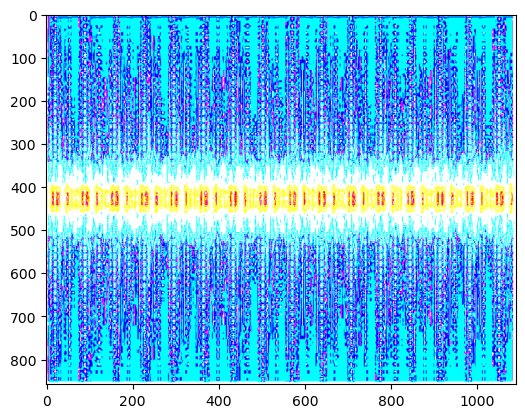

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow as tf

def remove_white_frame(image, threshold=0.95):
    """Removes the white frame from an image tensor."""
    # Convert image to grayscale
    gray = tf.image.rgb_to_grayscale(image)
    #plt.imshow(gray.numpy())
    #plt.show()
    
    # Create a mask of white areas
    mask = tf.where(gray < threshold, 1.0, 0.0)
    #plt.imshow(mask.numpy())
    #print(mask.shape)
    #plt.show()
    # Find bounding box coordinates
    mask = tf.reduce_max(mask, axis=-1)  # Remove the last dimension (grayscale)
    rows = tf.reduce_max(mask, axis=1)  # Max along width
    cols = tf.reduce_max(mask, axis=0)  # Max along height

    # Get the first and last non-zero row and column
    row_start = tf.argmax(rows, output_type=tf.int32)
    row_end = tf.shape(rows)[0] - tf.argmax(tf.reverse(rows, [0]), output_type=tf.int32)
    col_start = tf.argmax(cols, output_type=tf.int32)
    col_end = tf.shape(cols)[0] - tf.argmax(tf.reverse(cols, [0]), output_type=tf.int32)

    # Crop the image
    cropped_image = image[row_start:row_end, col_start:col_end, :]

    return cropped_image

def load_and_preprocess_image(image_path) -> tf.Tensor:
    """Loads an image, removes the white frame, resizes it, and normalizes pixel values."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    print(image.dtype)
    image = tf.cast(image, tf.float32)
    image = image / 255  # Convert to float32 and normalize
    print(image.shape)
    image = remove_white_frame(image)  # Remove white frame
    print(image.shape)
    #image = tf.image.resize(image, resize)  # Resize the trimmed image
    image = image * 255
    
    return image



# Load and preprocess the image
image_tensor = load_and_preprocess_image(image_path = "/Users/jackvittori/Desktop/uav-classification/images/2_blade_rotor/figure3.jpg")
print(image_tensor.shape)
print(image_tensor.dtype)
print(tf.reduce_max(image_tensor))
# Convert to NumPy and display
plt.imshow(image_tensor.numpy(), vmin=0, vmax=255)  # Convert tensor to NumPy array
plt.savefig("/Users/jackvittori/Desktop/image_tensor.png")
plt.show()

In [3]:
import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


ValueError: device must be a tf.config.PhysicalDevice, but got: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17399055540026388252
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 2175419617544970792
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


2025-03-13 10:43:25.892554: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-13 10:43:25.892592: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-13 10:43:25.892598: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-03-13 10:43:25.892636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-13 10:43:25.892646: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
